In [1]:
# If no torchvision locally, uncomment the next line and run it once:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

import os, random, math, time 
from pathlib import Path 

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import DataLoader 

import torchvision 
from torchvision import datasets, transforms 

import numpy as np 
import matplotlib.pyplot as plt 

SEED = 42 
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = torch.device(device)
DEVICE

device(type='cpu')

## 1. Data: download transform and inspect
We download MNIST (70k images of handwritten digits, 28*28 grayscale) using `torchvision.datasets.MNIST`

**Transforms used** :
* `ToTensor()` : converts PIL images to PyTorch tensors in [0,1]
* `Normalize((0.1307,), (0.3081,))` standardizes pixel values using the dataset's mean and std for faster, stabler training

In [2]:
DATA_DIR = Path("./data")

transform = transforms.Compose([
    transforms.ToTensor(),                    # [H,W] -> [1,H,W], values in [0,1]
    transforms.Normalize((0.1307,), (0.3081,))# standardize using MNIST stats
])

train_ds = torchvision.datasets.MNIST(
    root=DATA_DIR,
    train=True, 
    download=True,
    transform=transform
)

test_ds = torchvision.datasets.MNIST(
    root=DATA_DIR, 
    train=False, 
    download=True, 
    transform=transform
)

print(train_ds)
print(test_ds)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.27MB/s]

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


## 2. Peek at a sample and its statistics 
Let's pull a single (image, label) pair and check:

* the label (integer 0–9),
* the tensor shape (should be [1, 28, 28]),
* the value range, mean, and std after normalization,
* a visualization of the image.

Label: 4
Tensor shape: torch.Size([1, 28, 28])
Min / Max: -0.4242129623889923 2.821486711502075
Mean / Std: -0.10855599492788315 0.835247278213501


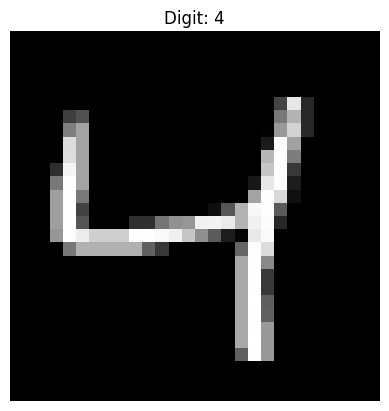

In [3]:
x, y = train_ds[2]
print("Label:", y)
print("Tensor shape:", x.shape) 

print("Min / Max:", float(x.min()), float(x.max()))
print("Mean / Std:", float(x.mean()), float(x.std()))

plt.figure() 
plt.title(f"Digit: {y}")
# Undo normalization for display: x*std + mean
x_vis = x * 0.3081 + 0.1307
plt.imshow(x_vis[0].numpy(), cmap="gray")
plt.axis("off")
plt.show()

## 3. Create DataLoaders
We wrap the datasets in `DataLoader`s to handle batching and (optionally) shuffling.
* **Batch size** : 64 is a common default for MNIST
* **Shuffle** : `True` for training; `False` for test 

In [4]:
BATCH_SIZE = 64

train_dl = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2, 
    pin_memory=True if DEVICE.type=="cuda" else False
)

test_dl = DataLoader(
    test_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2, 
    pin_memory=True if DEVICE.type=="cuda" else False
)

len(train_dl), len(test_dl)

(938, 157)

## 4. Define the CNN 
We'll use a simple but effective architecture for 28×28 grayscale images:

* Block 1: Conv(1→32, 3×3) → ReLU → Conv(32→32, 3×3) → ReLU → MaxPool(2×2)
* Block 2: Conv(32→64, 3×3) → ReLU → Conv(64→64, 3×3) → ReLU → MaxPool(2×2)
* Head: Flatten → Linear(1600→128) → ReLU → Dropout(0.25) → Linear(128→10)

With 28×28 input, two 2×2 pools reduce spatial size to 7×7. With 64 channels, that's 64×7×7 = 3136 features; our shaped math below confirms the exact number used here.

### Why does 28×28 become 7×7 after two 2×2 pooling layers?

Let’s break it down:

1. **Input size**: MNIST images are **28×28** pixels (height × width).

2. **MaxPool2d(2×2, stride=2)**:  
   - Looks at **non-overlapping 2×2 blocks** of pixels.  
   - Picks the maximum value from each block.  
   - Because stride=2, both height and width are reduced by **half**.

   $$
    text{Output size} = \frac{\text{Input size}}{\text{Stride}}
   $$

4. **First pooling**:  
   $$28 \div 2 = 14$$
   → Spatial size is now **14×14**.

5. **Second pooling**:  
   $$14 \div 2 = 7
   \]  
   → Spatial size is now **7×7**.

6. **Effect on features**:  
   If the CNN has 64 channels by this stage, the feature map shape is:  
   $$[\text{batch}, 64, 7, 7]$$
   Flattening gives:  
   $$
   64 \times 7 \times 7 = 3136 \text{ features}
   $$
   which are then passed to the fully connected layers.

👉 Each 2×2 pooling **halves** width and height. Doing it twice:  
**28 → 14 → 7**.


In [5]:
class CNN(nn.Module):
    def __init__(self, n_classes: int = 10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1x28x28 -> 32x28x28
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), # 32x28x28 -> 32x28x28
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),                 # 32x14x14

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 64x14x14
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # 64x14x14
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),                 # 64x7x7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),                                 # 64*7*7 = 3136
            nn.Linear(64*7*7, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

net = CNN().to(DEVICE)
net


CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

### What does `inplace=True` do in ReLU?

In PyTorch, many activation functions (like `ReLU`, `LeakyReLU`, etc.) have an `inplace` option.

- **`inplace=False` (default)**  
  The activation creates a **new tensor** for the output, leaving the input unchanged.

- **`inplace=True`**  
  The activation **modifies the input tensor directly**, without allocating new memory for the output.

#### Example
```python
import torch
import torch.nn as nn

x = torch.tensor([-1.0, 0.0, 2.0])

# Default (not inplace)
relu = nn.ReLU(inplace=False)
print(relu(x))   # tensor([0., 0., 2.])
print(x)         # tensor([-1.,  0.,  2.])  <- input is unchanged

# In-place version
relu_in = nn.ReLU(inplace=True)
x = torch.tensor([-1.0, 0.0, 2.0])
print(relu_in(x))  # tensor([0., 0., 2.])
print(x)           # tensor([0., 0., 2.])  <- input is modified directly

```

### General formula for output size in Conv2d / Pooling

For an input of size **H × W**, the output height/width after a convolution or pooling layer is:

$$
\text{Output size} = \left\lfloor \frac{H + 2P - K}{S} \right\rfloor + 1
$$

Where:
- **H** = input height (or width)  
- **K** = kernel size (filter size)  
- **P** = padding  
- **S** = stride  
- `floor` = round down to nearest integer  

---

#### Example 1: No padding, stride=1
- Input: 28×28  
- Kernel: 5 (K=5)  
- Padding: 0 (P=0)  
- Stride: 1 (S=1)  

$$
\frac{28 + 2(0) - 5}{1} + 1 = 24
$$

➡️ Output = **24×24**

---

#### Example 2: With padding=2
- Input: 28×28  
- Kernel: 5  
- Padding: 2  
- Stride: 1  

$$
\frac{28 + 2(2) - 5}{1} + 1 = 28
$$

➡️ Output = **28×28** (padding preserves size)

---

#### Example 3: With stride=2
- Input: 28×28  
- Kernel: 5  
- Padding: 2  
- Stride: 2  

$$
\frac{28 + 2(2) - 5}{2} + 1 = \frac{27}{2} + 1 = 14.5 \;\;\to\;\; 14
$$

➡️ Output = **14×14**

---

✅ **Intuition**:
- Larger **kernel (K)** → output shrinks.  
- Larger **padding (P)** → output grows (or preserves size).  
- Larger **stride (S)** → output shrinks (skips positions).  


### Derivation of the Conv2d / Pooling output size formula

The general formula is:

$$
\text{Output size} = \left\lfloor \frac{H + 2P - K}{S} \right\rfloor + 1
$$

Where:
- **H** = input size (height or width)
- **K** = kernel (filter) size
- **P** = padding
- **S** = stride

---

#### 1. No padding, stride = 1
- Input length = **H**
- Kernel length = **K**
- The first window starts at index 0
- The last window starts at index **H − K**
- Total number of valid positions:

$$
(H - K) + 1
$$

---

#### 2. Add padding
Padding extends the input by **P zeros** on each side.
Effective input length becomes:

$$
H + 2P
$$

Formula becomes:

$$
(H + 2P - K) + 1
$$

---

#### 3. Add stride
Stride **S** means we jump S pixels each step instead of 1.
So the number of positions is divided by S:

$$
\left\lfloor \frac{H + 2P - K}{S} \right\rfloor + 1
$$

The floor is needed because the window might not fit perfectly at the end.

---

#### 4. Extend to 2D
Apply the same reasoning to both height and width:

$$
\text{Output height} = \left\lfloor \frac{H + 2P - K}{S} \right\rfloor + 1
$$

$$
\text{Output width} = \left\lfloor \frac{W + 2P - K}{S} \right\rfloor + 1
$$

---

✅ **Intuition**:
- Larger **K** → output shrinks (kernel covers more input).  
- Larger **P** → output grows (padding gives extra room).  
- Larger **S** → output shrinks (fewer steps when skipping).  


### Derivation of the Conv2d / Pooling output size formula (with examples)

The general formula is:

$$
\text{Output size} = \left\lfloor \frac{H + 2P - K}{S} \right\rfloor + 1
$$

Where:
- **H** = input size (height or width)  
- **K** = kernel (filter) size  
- **P** = padding  
- **S** = stride  
- `floor` = round down to nearest integer  

---

#### 1. No padding, stride = 1
Formula:

$$
(H - K) + 1
$$

**Example**:  
- Input size = 7  
- Kernel size = 3  
- Padding = 0  
- Stride = 1

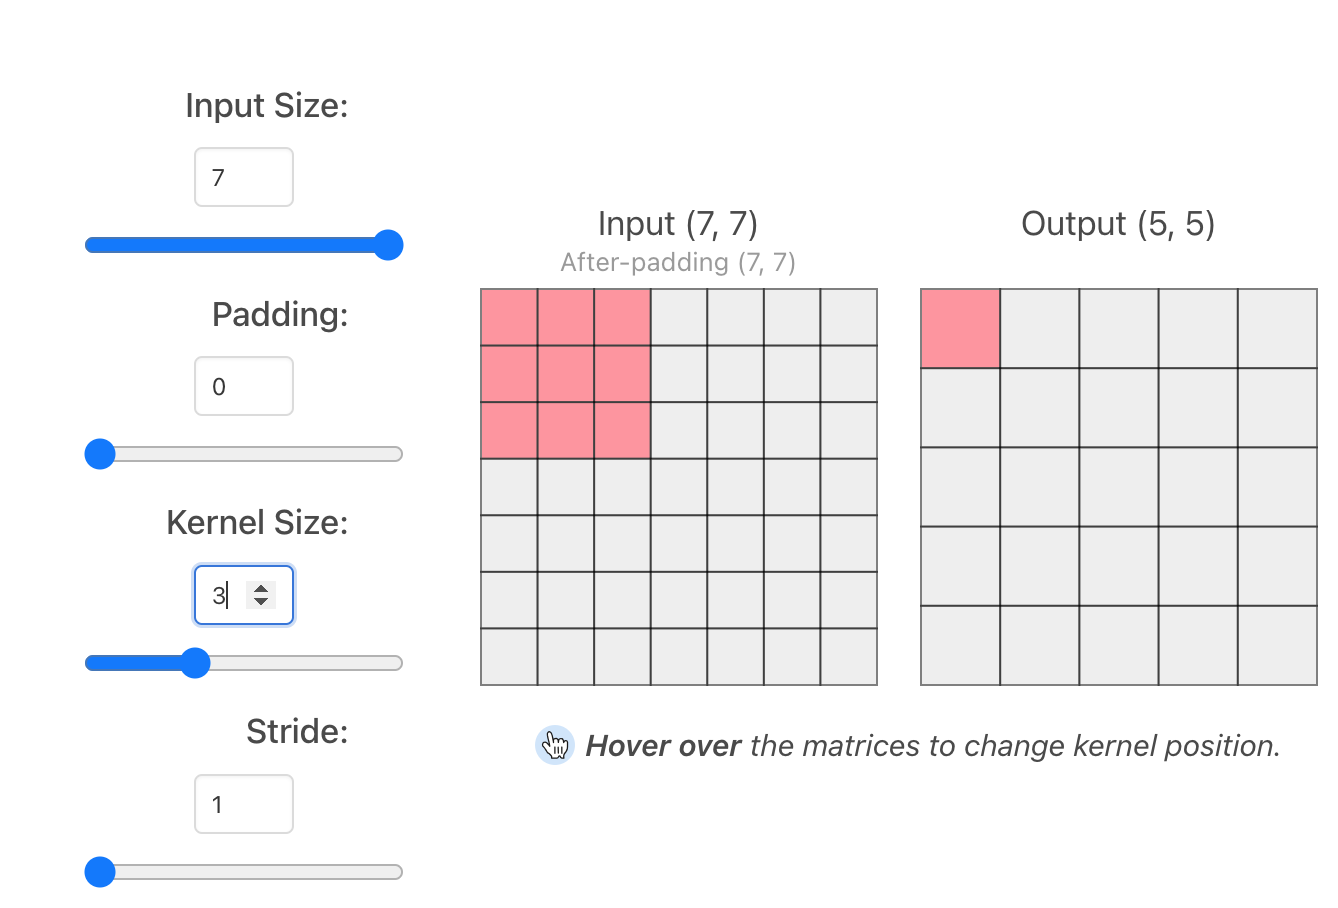

$$
(7 - 3) + 1 = 5
$$

➡️ Output size = **5**

---

#### 2. With padding
Formula:

$$
(H + 2P - K) + 1
$$

**Example**:  
- Input size = 7  
- Kernel size = 3  
- Padding = 1  
- Stride = 1  

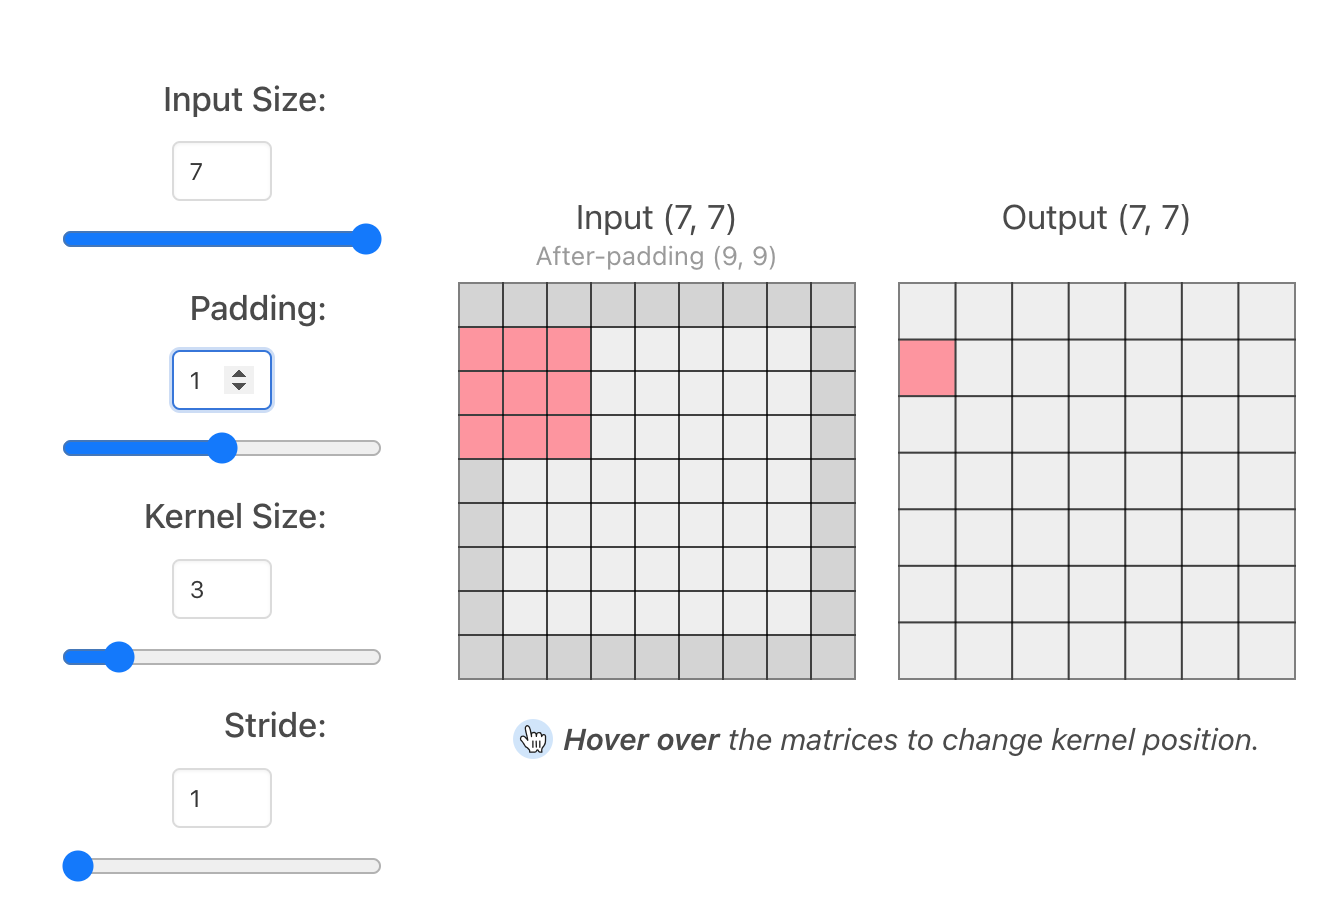

$$
(7 + 2(1) - 3) + 1 = 7
$$

➡️ Output size = **7** (padding preserves the input size here)

---

#### 3. With stride
Formula:

$$
\left\lfloor \frac{H + 2P - K}{S} \right\rfloor + 1
$$

**Example**:  
- Input size = 7  
- Kernel size = 3  
- Padding = 1  
- Stride = 2

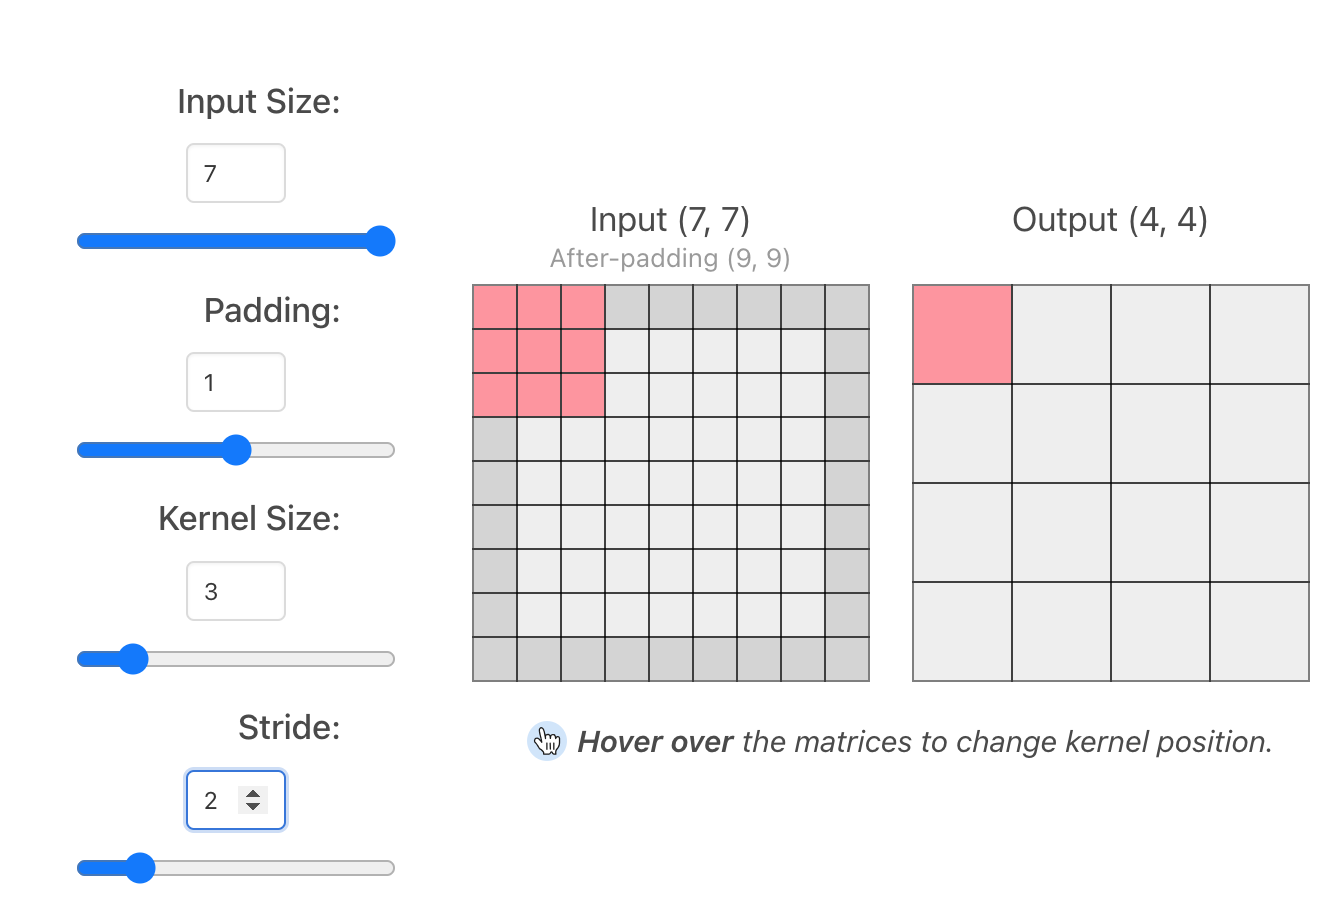

$$
\left\lfloor \frac{7 + 2(1) - 3}{2} \right\rfloor + 1
= \left\lfloor \frac{6}{2} \right\rfloor + 1
= 3 + 1 = 4
$$

➡️ Output size = **4**

---

#### 4. Extend to 2D
Apply the formula separately to height and width.

**Example**:  
- Input size = 28×28  
- Kernel size = 5  
- Padding = 2  
- Stride = 2  

Height:

$$
\left\lfloor \frac{28 + 2(2) - 5}{2} \right\rfloor + 1
= \left\lfloor \frac{27}{2} \right\rfloor + 1
= 13 + 1 = 14
$$

Width is the same.  
➡️ Output size = **14×14**

---

✅ **Summary of effects**
- Larger **K** → output shrinks.  
- Larger **P** → output grows (or keeps same size).  
- Larger **S** → output shrinks (fewer steps).  


## 5. Sanity checks: parameter count & tensor shapes
Before training, it's good practice to:
* Count parameters to ensure the model is the size you expect.
* Run a forward pass on dummy input to confirm shapes align (batch, channels, height, width).

In [6]:
def count_parameters(model: nn.Module) -> int: 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_parameters(net)}")

# shape check with a single example 
x0, y0 = train_ds[0]
x0 = x0.unsqueeze(0).to(DEVICE) # add batch dim -> [1,1,28,28]
with torch.no_grad():
    logits = net(x0)

print("Logits shape (should be [1,10]):", tuple(logits.shape))

Trainable parameters: 467818
Logits shape (should be [1,10]): (1, 10)


## 6. Training setup
We use:
* **Loss** : `CrossEntropyLoss` (handles `LogSoftmax` internally, expects raw logits)
* **Optimizer** : `Adam` with a learning rate `lr = 1e-3`
* **Epochs** : 3-5 is often enough for MNIST on this model

In [7]:
from tqdm import tqdm 

EPOCHS = 3
LR = 1e-3

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    net.parameters(),
    lr=LR
)

## 7. Train the model
For each epoch we:
1. Set the network to `train()` mode
2. Loop over batches: forward -> loss -> backward -> optimizer step
3. Track running loss and accuracy
4. Optionally, evaluate on the test set at the end of the epoch

The progress bar shows batch-wise updates

In [8]:
train_history = {"loss": [], "acc": []}
val_history = {"loss": [], "acc": []}

for epoch in range(1, EPOCHS+1):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_dl, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)
    for xb, yb in pbar:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)

        optimizer.zero_grad()
        logits = net(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

        pbar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_history["loss"].append(epoch_loss)
    train_history["acc"].append(epoch_acc)

    # quick validation at epoch end
    net.eval()
    val_loss = 0.0
    v_correct = 0
    v_total = 0
    with torch.no_grad():
        for xb, yb in test_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = net(xb)
            loss = loss_fn(logits, yb)
            val_loss += loss.item() * xb.size(0)
            v_correct += (logits.argmax(dim=1) == yb).sum().item()
            v_total += yb.size(0)

    val_loss /= v_total
    val_acc = v_correct / v_total
    val_history["loss"].append(val_loss)
    val_history["acc"].append(val_acc)

    print(f"Epoch {epoch:2d} | train loss {epoch_loss:.4f} acc {epoch_acc:.4f} | val loss {val_loss:.4f} acc {val_acc:.4f}")


Epoch  1 | train loss 0.1554 acc 0.9524 | val loss 0.0394 acc 0.9873


Epoch  2 | train loss 0.0528 acc 0.9841 | val loss 0.0338 acc 0.9891


Epoch  3 | train loss 0.0359 acc 0.9890 | val loss 0.0403 acc 0.9877


## 8. Plot training curves

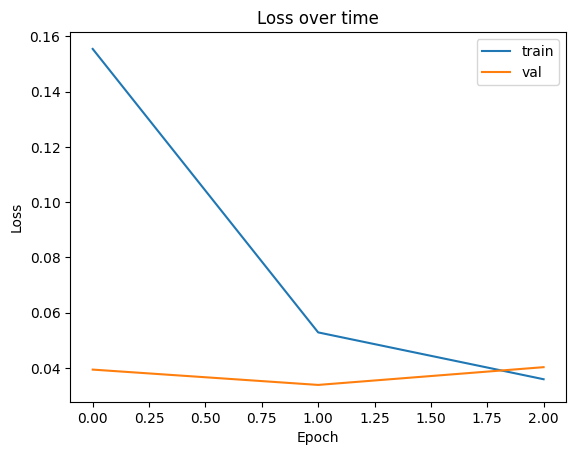

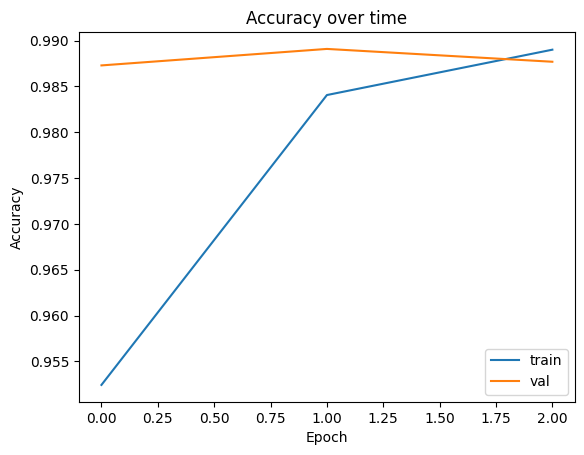

In [9]:
# Loss curve
plt.figure()
plt.plot(train_history["loss"], label="train")
plt.plot(val_history["loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over time")
plt.legend()
plt.show()

# Accuracy curve
plt.figure()
plt.plot(train_history["acc"], label="train")
plt.plot(val_history["acc"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over time")
plt.legend()
plt.show()


## 9. Single-example inference with probabilities

True label: 7
Predicted label: 7
Probabilities: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00']


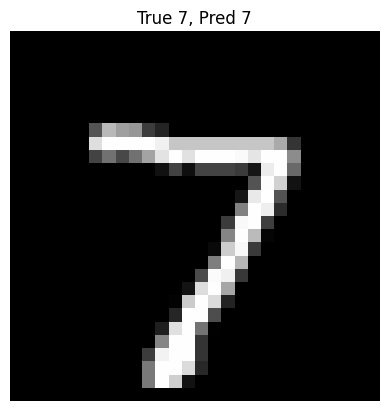

In [10]:
net.eval()
x1, y1 = test_ds[0]
with torch.no_grad():
    probs = F.softmax(net(x1.unsqueeze(0).to(DEVICE))[0], dim=0).cpu()

print("True label:", y1)
print("Predicted label:", int(probs.argmax().item()))
print("Probabilities:", [f"{p:.2f}" for p in probs.tolist()])

plt.figure()
x1_vis = x1 * 0.3081 + 0.1307
plt.title(f"True {y1}, Pred {int(probs.argmax().item())}")
plt.imshow(x1_vis[0].numpy(), cmap="gray")
plt.axis("off")
plt.show()


## 10. Evaluate on the test set

Test accuracy: 0.9877


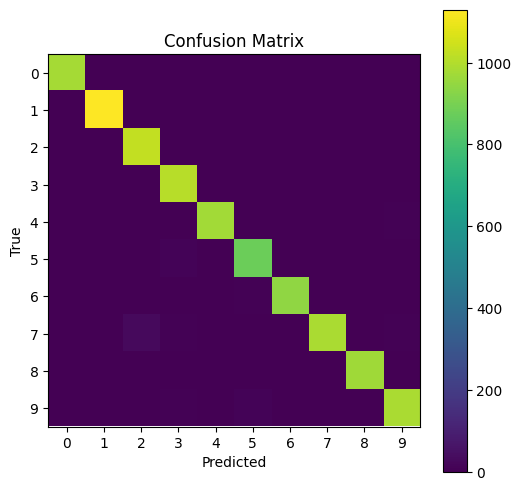

In [11]:
net.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(DEVICE)
        logits = net(xb)
        preds = logits.argmax(dim=1).cpu()
        all_preds.append(preds)
        all_targets.append(yb)

preds = torch.cat(all_preds)
targets = torch.cat(all_targets)

accuracy = (preds == targets).float().mean().item()
print(f"Test accuracy: {accuracy:.4f}")

# Confusion matrix without sklearn
num_classes = 10
cm = torch.zeros(num_classes, num_classes, dtype=torch.int32)
for t, p in zip(targets, preds):
    cm[t, p] += 1

plt.figure(figsize=(6,6))
plt.imshow(cm.numpy(), interpolation="nearest")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(num_classes))
plt.yticks(range(num_classes))
plt.colorbar()
plt.show()


### Why `argmax` on logits (no softmax first)?

- **Logits** are the raw outputs from the network, before softmax.
- `CrossEntropyLoss` in PyTorch expects logits and applies `LogSoftmax` internally.
- When we want the **predicted class**, we just need the index of the maximum.
- **Key fact**: softmax preserves the ordering of values.
  - The largest logit corresponds to the largest probability.
  - So:
  
  $$
  \arg\max(\text{logits}) = \arg\max(\text{softmax}(\text{logits}))
  $$

➡️ Using softmax here would be redundant.

---

### Why `.cpu()`?

- If training runs on **GPU**, tensors live in GPU memory.
- Libraries like **NumPy** and **Matplotlib** only work with **CPU tensors**.
- `.cpu()` moves the tensor to the CPU so we can do:

```python
preds = logits.argmax(dim=1)   # on GPU
preds = preds.cpu()            # move to CPU
preds = preds.numpy()          # convert to numpy
```
➡️ `.cpu()` is essential before converting to NumPy or plotting.


## Save & Reload the model 

In [12]:
MODEL_PATH = Path("./mnist_cnn.pt")
torch.save(net.state_dict(), MODEL_PATH) 
print(f"Saved to: {MODEL_PATH.resolve()}")

Saved to: /kaggle/working/mnist_cnn.pt


In [13]:
# example reload 
reloaded = CNN().to(DEVICE)
reloaded.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
reloaded.eval() 
print("Reloaded model ready!")

reloaded

Reloaded model ready!


CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)